In [1]:
import pandas as pd

df_raw = pd.read_csv('gender-classification.csv', encoding='latin1')

In [2]:
# 目的変数をいじる

## 目的変数を確認
obj_col = 'gender'
print('生データ\n{}'.format(df_raw[obj_col].value_counts()))

## male と femaleを抽出
df = df_raw.loc[ (df_raw[obj_col]=='male') | (df_raw[obj_col]=='female')]

## indexを振り直さないとlocメソッドでerrorが出る
df = df.reset_index(drop=True)

##ラベルを整数に変換
df.loc[ df[obj_col]=='male' , obj_col] = 0
df.loc[ df[obj_col]=='female' , obj_col] = 1

## 目的変数の型変換
df.loc[:, obj_col ] = df.loc[:, obj_col ].astype(int)

print('修正後のデータ\n{}'.format(df[obj_col].value_counts()))

生データ
female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64
修正後のデータ
1    6700
0    6194
Name: gender, dtype: int64


In [3]:
# 説明変数をいじる
## description : 頻度表 + naive bayse
## text : 分散表現 (word2vec or fasttext)  or 頻度表 + naive bayse
## name : 文字単位
## link_color : RGBで各次元を形成
## sidebar_color : RGBで各次元を形成

# 保留項目
## fav_number : 不明
## retweet_count : 不明
## profileimage : 学習済みモデルから分類する? コスト高そう そもそも人かどうか判断できる時点で予測するまでもない

## 性別判定の信頼度が1.0を対象に学習する
df = df.loc[ df['gender:confidence'] >=1.0 ]
df = df.reset_index(drop=True)
df = df.dropna(subset=['name'])
df = df.reset_index(drop=True)

print('修正後のデータ2\n{}'.format(df[obj_col].value_counts()))

修正後のデータ2
1    5367
0    4653
Name: gender, dtype: int64


In [8]:
import numpy as np
from keras.utils import to_categorical

y = to_categorical(np.asarray(df.gender.values).astype('float32'))

In [4]:
df.name.apply(lambda x: len(x)).describe()

count    10020.000000
mean        11.145709
std          2.526815
min          2.000000
25%          9.000000
50%         11.000000
75%         13.000000
max         15.000000
Name: name, dtype: float64

In [5]:
from collections import Counter

unique_symbols = Counter()

for _, message in df.name.iteritems():
    unique_symbols.update(message)
    
print("Unique symbols:", len(unique_symbols))

num_unique_symbols = len(unique_symbols)

Unique symbols: 63


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(
    char_level=True,
    filters=None,
    lower=False,
)

Using TensorFlow backend.
/home/fukuyama/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
# train test split
from sklearn.model_selection import train_test_split

df_x_train, df_x_test, y_train, y_test = train_test_split(df.name.values, y, test_size = 0.1, random_state = 0, stratify=df.gender.values)

In [10]:
tokenizer.fit_on_texts(df_x_train)

max_len = 15

train_sequences = tokenizer.texts_to_sequences(df_x_train)
x_train = pad_sequences(train_sequences, maxlen=max_len)

test_sequences = tokenizer.texts_to_sequences(df_x_test)
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [13]:
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.callbacks import EarlyStopping

model = models.Sequential()
model.add(Embedding(num_unique_symbols, num_unique_symbols, input_length=max_len))
model.add(Bidirectional(LSTM(max_len)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 63)            3969      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30)                9480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 13,511
Trainable params: 13,511
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(patience=10, monitor='val_loss')])

Train on 8116 samples, validate on 902 samples
Epoch 1/30
8116/8116 [==============================] - 18s 2ms/step - loss: 0.6588 - acc: 0.5987 - val_loss: 0.6464 - val_acc: 0.6086
Epoch 2/30
8116/8116 [==============================] - 17s 2ms/step - loss: 0.6314 - acc: 0.6463 - val_loss: 0.6494 - val_acc: 0.6264
Epoch 3/30
8116/8116 [==============================] - 18s 2ms/step - loss: 0.6267 - acc: 0.6447 - val_loss: 0.6419 - val_acc: 0.6231
Epoch 4/30
8116/8116 [==============================] - 18s 2ms/step - loss: 0.6220 - acc: 0.6498 - val_loss: 0.6536 - val_acc: 0.6286
Epoch 5/30
8116/8116 [==============================] - 17s 2ms/step - loss: 0.6189 - acc: 0.6529 - val_loss: 0.6384 - val_acc: 0.6297
Epoch 6/30
8116/8116 [==============================] - 18s 2ms/step - loss: 0.6157 - acc: 0.6602 - val_loss: 0.6354 - val_acc: 0.6463
Epoch 7/30
8116/8116 [==============================] - 18s 2ms/step - loss: 0.6120 - acc: 0.6578 - val_loss: 0.6371 - val_acc: 0.6286
Epoch 8/

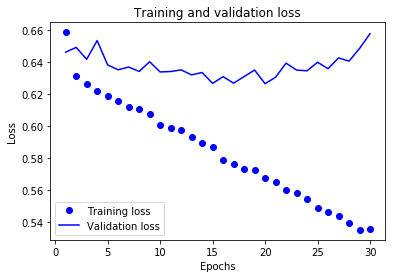

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

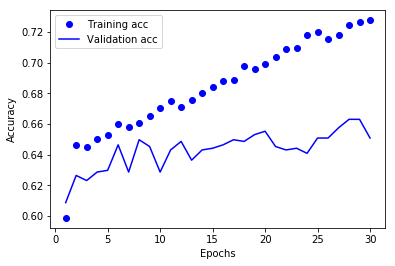

In [16]:
plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
model.evaluate(x_test, y_test)

1002/1002 [==============================] - 1s 577us/step


[0.67218377644906258, 0.63972055912017822]